In [1]:
import os
import zipfile
import random
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile
import matplotlib.pyplot as plt
import numpy as np

from tensorflow import keras
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras import optimizers, losses
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing import image

In [2]:
source_path = '/content/Cow-Disease'

source_path_healthy = os.path.join(source_path, '/content/Cow-Disease/Healthy')
source_path_lumpy = os.path.join(source_path, '/content/Cow-Disease/Lumpy')

# Deletes all non-image files (there are two .db files bundled into the dataset)
!find /content/Cow-Disease/ -type f ! -name "*.png" -exec rm {} +

# os.listdir returns a list containing all files under the given path
print(f"There are {len(os.listdir(source_path_healthy))} images of healthy.")
print(f"There are {len(os.listdir(source_path_lumpy))} images of lumpy.")

There are 700 images of healthy.
There are 299 images of lumpy.


In [3]:
root_dir = '/content/Cow-Diseases'

# Empty directory to prevent FileExistsError is the function is run several times
if os.path.exists(root_dir):
  shutil.rmtree(root_dir)

# GRADED FUNCTION: create_train_val_dirs
def create_train_val_dirs(root_path):
  """
  Creates directories for the train and test sets

  Args:
    root_path (string) - the base directory path to create subdirectories from

  Returns:
    None
  """

  ### START CODE HERE

  # HINT:
  # Use os.makedirs to create your directories with intermediate subdirectories
  # Don't hardcode the paths. Use os.path.join to append the new directories to the root_path parameter

  os.makedirs(os.path.join(root_path, 'training'))
  os.makedirs(os.path.join(f'{root_path}/training', 'lumpys'))
  os.makedirs(os.path.join(f'{root_path}/training', 'healthys'))
  os.makedirs(os.path.join(root_path, 'validation'))
  os.makedirs(os.path.join(f'{root_path}/validation', 'lumpys'))
  os.makedirs(os.path.join(f'{root_path}/validation', 'healthys'))


  ### END CODE HERE


try:
  create_train_val_dirs(root_path=root_dir)
except FileExistsError:
  print("You should not be seeing this since the upper directory is removed beforehand")

In [4]:
for rootdir, dirs, files in os.walk(root_dir):
    for subdir in dirs:
        print(os.path.join(rootdir, subdir))

/content/Cow-Diseases/validation
/content/Cow-Diseases/training
/content/Cow-Diseases/validation/healthys
/content/Cow-Diseases/validation/lumpys
/content/Cow-Diseases/training/healthys
/content/Cow-Diseases/training/lumpys


In [5]:
def split_data(SOURCE_DIR, TRAINING_DIR, VALIDATION_DIR, SPLIT_SIZE):
  shuffled_source = random.sample(os.listdir(SOURCE_DIR), len(os.listdir(SOURCE_DIR)))
  training_number = int(len(shuffled_source) * SPLIT_SIZE)
  ### START CODE HERE
  i = 0
  target = TRAINING_DIR

  for item in shuffled_source:
    item_source = os.path.join(SOURCE_DIR, item)
    if os.path.getsize(item_source) == 0:
      print(f'{item} is zero length, so ignoring.')
    else:
      copyfile(item_source, os.path.join(target, item))
      i += 1

    # Switch copy target to TESTING
    if i == training_number:
      target = VALIDATION_DIR


  ### END CODE HERE

In [6]:
HEALTHYS_SOURCE_DIR = "/content/Cow-Disease/Healthy"
LUMPYS_SOURCE_DIR = "/content/Cow-Disease/Lumpy"

TRAINING_DIR = "/content/Cow-Diseases/training"
VALIDATION_DIR = "/content/Cow-Diseases/validation"

TRAINING_HEALTHYS_DIR = os.path.join(TRAINING_DIR, "healthys/")
VALIDATION_HEALTHYS_DIR = os.path.join(VALIDATION_DIR, "healthys/")

TRAINING_LUMPYS_DIR = os.path.join(TRAINING_DIR, "lumpys/")
VALIDATION_LUMPYS_DIR = os.path.join(VALIDATION_DIR, "lumpys/")

if len(os.listdir(TRAINING_HEALTHYS_DIR)) > 0:
  for file in os.scandir(TRAINING_HEALTHYS_DIR):
    os.remove(file.path)
if len(os.listdir(TRAINING_LUMPYS_DIR)) > 0:
  for file in os.scandir(TRAINING_LUMPYS_DIR):
    os.remove(file.path)
if len(os.listdir(VALIDATION_HEALTHYS_DIR)) > 0:
  for file in os.scandir(VALIDATION_HEALTHYS_DIR):
    os.remove(file.path)
if len(os.listdir(VALIDATION_LUMPYS_DIR)) > 0:
  for file in os.scandir(VALIDATION_LUMPYS_DIR):
    os.remove(file.path)


split_size = .9

split_data(HEALTHYS_SOURCE_DIR, TRAINING_HEALTHYS_DIR , VALIDATION_HEALTHYS_DIR , split_size)
split_data(LUMPYS_SOURCE_DIR, TRAINING_LUMPYS_DIR, VALIDATION_LUMPYS_DIR, split_size)

print(f"\n\nOriginal Healthys directory has {len(os.listdir(HEALTHYS_SOURCE_DIR))} images")
print(f"Original Lumpys directory has {len(os.listdir(LUMPYS_SOURCE_DIR))} images\n")

print(f"There are {len(os.listdir(TRAINING_HEALTHYS_DIR))} images of Healthy for training")
print(f"There are {len(os.listdir(TRAINING_LUMPYS_DIR))} images of lumpy for training")
print(f"There are {len(os.listdir(VALIDATION_HEALTHYS_DIR))} images of Healthy for validation")
print(f"There are {len(os.listdir(VALIDATION_LUMPYS_DIR))} images of lumoy for validation")



Original Healthys directory has 700 images
Original Lumpys directory has 299 images

There are 630 images of Healthy for training
There are 269 images of lumpy for training
There are 70 images of Healthy for validation
There are 30 images of lumoy for validation


In [7]:
def train_val_generators(TRAINING_DIR, VALIDATION_DIR):
  train_datagen = ImageDataGenerator(rescale = 1./255.,
                                     rotation_range = 40,
                                     width_shift_range = 0.2,
                                     height_shift_range = 0.2,
                                     shear_range = 0.2,
                                     zoom_range = 0.2,
                                     horizontal_flip = True,
                                     fill_mode = 'nearest')

  train_generator = train_datagen.flow_from_directory(directory = TRAINING_DIR,
                                                      batch_size = 45,
                                                      class_mode = 'binary',
                                                      target_size = (150, 150))

  validation_datagen =ImageDataGenerator(rescale = 1./255.)


  validation_generator = validation_datagen.flow_from_directory(directory = VALIDATION_DIR,
                                                                batch_size = 5,
                                                                class_mode = 'binary',
                                                                target_size = (150, 150))

  return train_generator, validation_generator

In [8]:
train_generator, validation_generator = train_val_generators(TRAINING_DIR, VALIDATION_DIR)

Found 899 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


In [14]:
# Import necessary libraries
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

# GRADED FUNCTION: create_model
def create_model():
    # Load MobileNetV2 model pre-trained on ImageNet data
    base_model = MobileNetV2(input_shape=(150, 150, 3), include_top=False, weights='imagenet')

    # Freeze the layers of the pre-trained model
    for layer in base_model.layers:
        layer.trainable = False

    # Create a new model on top of the pre-trained model
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(512, activation='relu'),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model


In [15]:
model = create_model()

In [16]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 5, 5, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d_1  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_2 (Dense)             (None, 512)               655872    
                                                                 
 dense_3 (Dense)             (None, 1)                 513       
                                                                 
Total params: 2914369 (11.12 MB)
Trainable params: 656385 (2.50 MB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


In [17]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',  # Memantau metrik yang ingin dihentikan, contohnya val_loss
    patience=3,  # Jumlah epoch yang harus melewati tanpa perbaikan sebelum pelatihan dihentikan
    restore_best_weights=True  # Mengembalikan bobot model ke iterasi terbaik
)

In [18]:
history = model.fit(train_generator,
                    epochs=100,
                    verbose=1,
                    validation_data=validation_generator,callbacks=[early_stopping])

Epoch 1/100
20/20 [==============================] - 28s 1s/step - loss: 0.9025 - accuracy: 0.7898 - val_loss: 0.2406 - val_accuracy: 0.9200
Epoch 2/100
20/20 [==============================] - 22s 1s/step - loss: 0.3159 - accuracy: 0.8754 - val_loss: 0.1817 - val_accuracy: 0.9500
Epoch 3/100
20/20 [==============================] - 24s 1s/step - loss: 0.2263 - accuracy: 0.9143 - val_loss: 0.1381 - val_accuracy: 0.9300
Epoch 4/100
20/20 [==============================] - 23s 1s/step - loss: 0.1810 - accuracy: 0.9299 - val_loss: 0.1133 - val_accuracy: 0.9700
Epoch 5/100
20/20 [==============================] - 24s 1s/step - loss: 0.1395 - accuracy: 0.9433 - val_loss: 0.1318 - val_accuracy: 0.9600
Epoch 6/100
20/20 [==============================] - 24s 1s/step - loss: 0.1541 - accuracy: 0.9399 - val_loss: 0.1089 - val_accuracy: 0.9500
Epoch 7/100
20/20 [==============================] - 23s 1s/step - loss: 0.1364 - accuracy: 0.9455 - val_loss: 0.1137 - val_accuracy: 0.9500


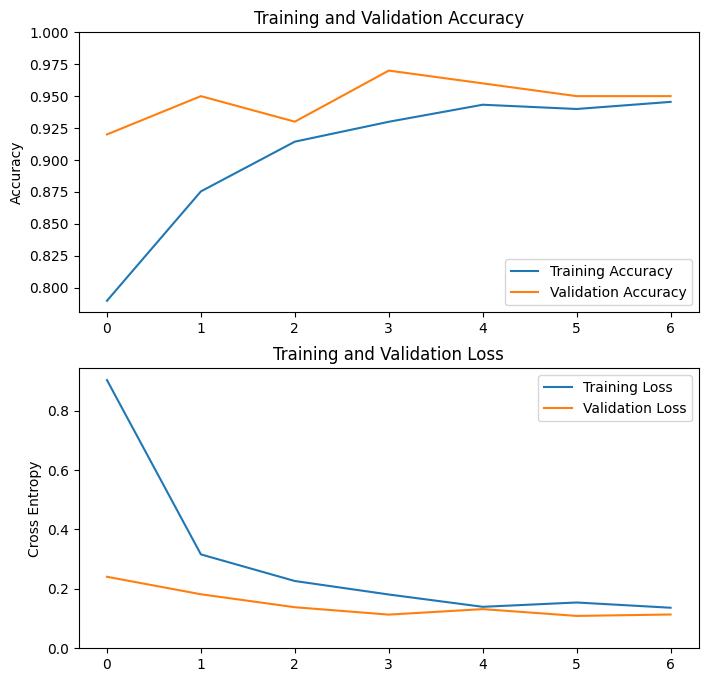

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

# ________________ Graph 1 -------------------------

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

# ________________ Graph 2 -------------------------

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.show()


In [20]:
test_loss, test_acc = model.evaluate(validation_generator)
print('test accuracy : ', test_acc)

20/20 [==============================] - 3s 162ms/step - loss: 0.1133 - accuracy: 0.9700
test accuracy :  0.9700000286102295


In [21]:
model.save("Model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


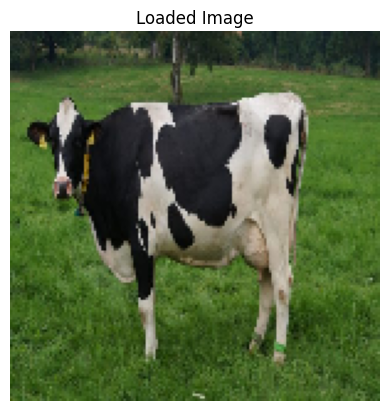

1/1 [==============================] - 1s 1s/step


Probability for Lumpy Class: 30.57343363761902 %
Classified: Lumpy 




In [45]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow import keras

def predict(img_rel_path, model_path="Model.h5", threshold=8):
    # Check if the model file exists
    if not os.path.exists(model_path):
        print(f"Error: Model file '{model_path}' not found.")
        return

    # Load the model
    loaded_best_model = keras.models.load_model(model_path)

    # Import Image from the path with size of (150, 150)
    img = image.load_img(img_rel_path, target_size=(150, 150))

    # Convert Image to a numpy array
    img = image.img_to_array(img)

    # Scaling the Image Array values between 0 and 1
    img = img / 255.0

    # Plotting the Loaded Image
    plt.title("Loaded Image")
    plt.axis('off')
    plt.imshow(img.squeeze())
    plt.show()

    # Get the Predicted Label for the loaded Image
    p = loaded_best_model.predict(img[np.newaxis, ...])

    # Probability for the Lumpy class (index 0)
    lumpy_probability = p[0][0] * 100

    print("\n\nProbability for Lumpy Class:", lumpy_probability, "%")

    # Classify based on the threshold
    if lumpy_probability >= threshold:
        predicted_class = 'Lumpy'
    else:
        predicted_class = 'Healthy'

    print("Classified:", predicted_class, "\n\n")

# Example usage:
img_path = "/content/sapi-friesien-holstein-640x384.jpg"  # Replace with the path to your image
predict(img_path)

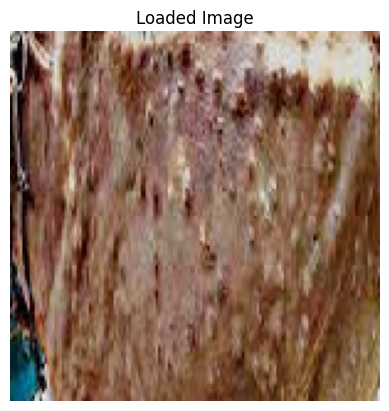

1/1 [==============================] - 1s 1s/step


Maximum Probability:  0.99898475
Classified: lumpy 



-------------------Individual Probability--------------------------------

LUMPY : 99.9 %


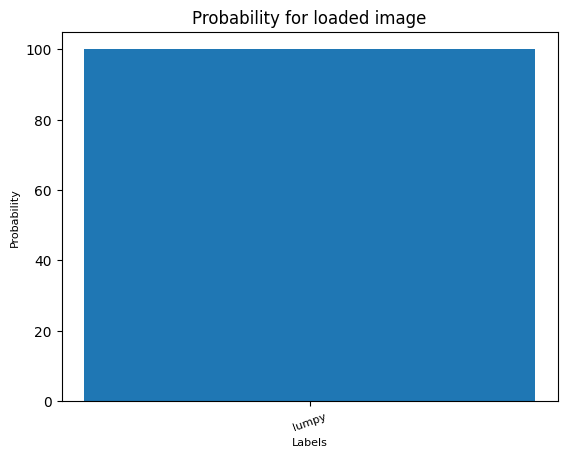

In [32]:
predict("/content/Cow-Disease/Lumpy/Lumpy Skin 22.png")

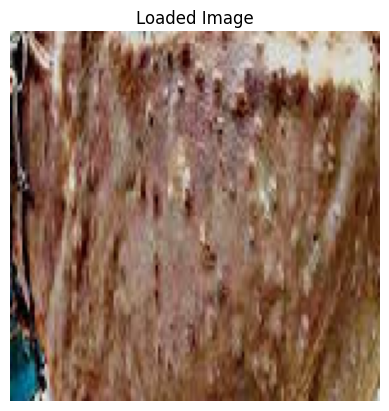

1/1 [==============================] - 0s 51ms/step


Maximum Probability:  0.99898475
Classified: lumpy 



-------------------Individual Probability--------------------------------

LUMPY : 99.9 %


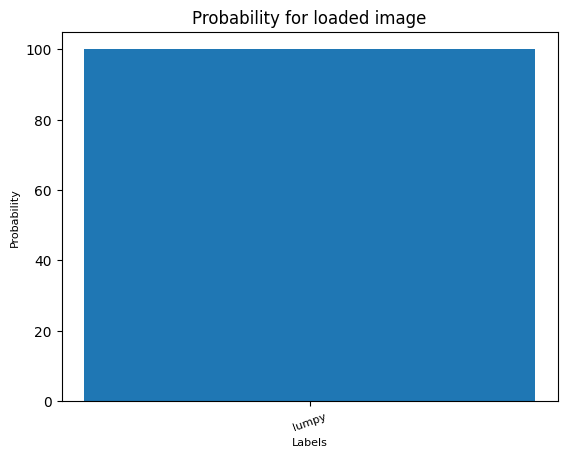

In [29]:
predict("/content/Cow-Disease/Lumpy/Lumpy Skin 22.png")